<a href="https://colab.research.google.com/github/djdumpling/Machine-Learning-Prince-/blob/main/10_2_Convolution_for_MNIST_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/greydanus/mnist1d
# install the dataset from a git

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-_pfjp2jm
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-_pfjp2jm
  Resolved https://github.com/greydanus/mnist1d to commit 350929d12f4c9a4b7355e0c96604e41b9239bdb4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post9-py3-none-any.whl size=14497 sha256=2830d923166b8b45ad8d92c343f37de753ab424cd466cf3c15b42998e6338c6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-a3og14eo/wheels/41/95/55/45fcf7d38cfa97e35682da6c5017d4513729131326ce935371
Successfully built mnist1d


In [ ]:
import numpy as np # for arrays
import os # we don't actually need this since this is for running stuff locally
import torch, torch.nn as nn # for neural network framework
from torch.utils.data import TensorDataset, DataLoader
# 1) wrapping tensors
# 2) makes data iterable via Python
from torch.optim.lr_scheduler import StepLR # learning rate schedule
import matplotlib.pyplot as plt #plotting
import mnist1d #importing the data
import random #for getting train-validation split

In [ ]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_date.pkl', download = False, regenerate = False)
# not sure what these are doing

# the {} is related with the stuff inside .format(), i.e. len(data['y'])
# obv can replace y with x b.c. 1-1
# data['x'].shape[-1] refers to the last dimension of data['x']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_date.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [ ]:
train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']

In [ ]:
# %'s are replaced with things since %()

print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 1000 examples (columns), each of which has 40 dimensions (rows)


In [ ]:
# 40 offsets in the MNIST1D template
D_i = 40
# outputs corresponding to 10 digits
D_o = 10

# TODO Create a model with the following layers

model = nn.Sequential(
    nn.Conv1d(1, 15, 3, 2, padding = 'valid'),
    # 1. Conv, (input=length 40 and 1 channel, kernel size 3, stride 2, padding="valid", 15 output channels )
    nn.ReLU(),
    # 2. ReLU
    nn.Conv1d(15, 15, 3, 2, padding = 'valid'),
    # 3. Conv layer, (input=length 19 and 15 channels, kernel size 3, stride 2, padding="valid", 15 output channels )
    nn.ReLU(),
    # 4. ReLU
    nn.Conv1d(15, 15, 3, 2, padding = 'valid'),
    # 5. Conv layer, (input=length 9 and 15 channels, kernel size 3, stride 2, padding="valid", 15 output channels)
    nn.ReLU(),
    # 6. ReLU
    nn.Flatten(),
    # 7. Flatten (converts 4x15) to length 60
    nn.Linear(60,10)
    # 8. Linear layer (input size = 60, output size = 10)
)

In [ ]:
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear): # check if a layer is a linear layer
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

# He initalization for non-exploding or non-diminishing gradients
# also accounts for non-linear activations (i.e. ReLU)
# sets standard deviation to sqrt(2/n)
# bias = 0

Epoch     0, train loss 2.166656, train error 79.68,  val loss 2.175576, percent error 79.80
Epoch     1, train loss 1.587433, train error 62.50,  val loss 1.610324, percent error 67.20
Epoch     2, train loss 1.436424, train error 57.35,  val loss 1.470006, percent error 59.40
Epoch     3, train loss 1.286371, train error 52.88,  val loss 1.303442, percent error 55.50
Epoch     4, train loss 1.192649, train error 47.78,  val loss 1.227796, percent error 50.70
Epoch     5, train loss 1.132849, train error 44.85,  val loss 1.175930, percent error 48.30
Epoch     6, train loss 1.093146, train error 41.45,  val loss 1.148546, percent error 43.70
Epoch     7, train loss 0.883463, train error 35.70,  val loss 0.935728, percent error 39.20
Epoch     8, train loss 0.791120, train error 31.85,  val loss 0.849852, percent error 34.00
Epoch     9, train loss 0.821131, train error 33.07,  val loss 0.904173, percent error 34.90
Epoch    10, train loss 0.685825, train error 27.50,  val loss 0.75832

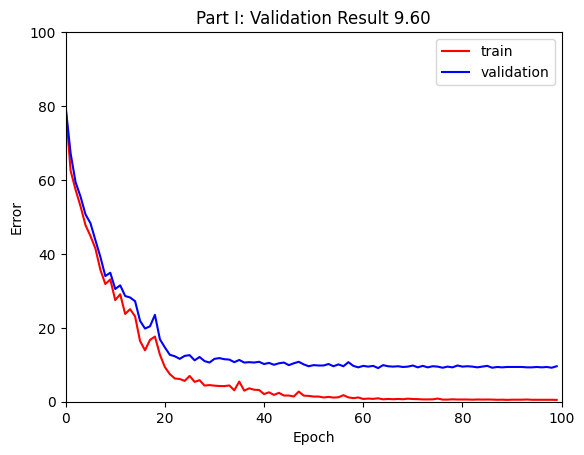

In [ ]:
# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
# create 100 dummy data points and store in data loader class
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long')).long()
x_val= torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long')).long()

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 100
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_val = np.zeros((n_epoch))
errors_val = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, data in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch[:,None,:])
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train[:,None,:])
  pred_val = model(x_val[:,None,:])
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_val[epoch]= loss_function(pred_val, y_val).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_val,'b-',label='validation')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Part I: Validation Result %3.2f'%(errors_val[-1]))
ax.legend()
plt.show()